# Overview

1. Given a star at REFO of known coordinates, astrometrically solve for the center of the MOSFIRE imaging FoV and calculate the distance and angle on the sky between the two points.
1. Subtract out the angle of the rotator (on the sky) to determine the distance (angle on the sky) and rotation (angle on instrument) between the two points.
1. Given a number of these measurements, fit the relationship between telescope elevation, rotator physical angle, and the 2D separation of the guider and instrument FoV.
1. Translate the differences to a motion of the guider (REFO) relative to the main instrument in units of guider pixels.

# Observing Procedure

1. OA: Pick a pointing star near desired EL.
1. OA: Choose rotator position angle (PA) near rotator drive angle 0.
1. OA: Slew to star using PO REF (rotator mode should be PositionAngle).
1. OA: Center star on REF using Ca, Ce adjustments and begin guiding.
1. SA: Note guide star name and coordinates (for insurance).
1. SA: Image field in J-band.
1. OA: Rotate 45 degrees (rotator mode should be PositionAngle).
1. OA: Center star on REF using Ca, Ce adjustments and begin guiding.
1. SA: Note guide star name and coordinates (for insurance).
1. SA: Image field in J-band.
1. Keep repeating steps 7-10 until you have rotated 360 degrees.
1. Then repeat for a new EL.

## Data Table

Raw data: for each image, fill in:
1. file name
1. telescope elevation
1. instrument PA
1. guider RA
1. guider Dec

Loop through all elements of the data table and derive the values in the measurements table.

From the image data, we derive:
1. the Measured Sky Angle: PA (East of North) between guider and instrument FoV.
1. the Physical Angle: The Angle between them after the instrument PA has been subtracted off.  This should be constant other than flexure.
1. the Separation: distance (in arcsec) between the two FoVs.  This should be constant other than flexure.

Relevant MOSFIRE keywords:

`show -s mosfire SKYPA0 SKYPA1 SKYPA2 SKYPA3 FCPA_EL`

MOSFIRE FITS header keywords:

`SKYPA0 SKYPA1 SKYPA2 SKYPA3 FCPA_EL`

In [108]:
from pathlib import Path

import ccdproc
from ccdproc import ImageFileCollection

from astropy.table import QTable, Column
from astropy import coordinates as c
from astropy import units as u
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.cm as cm

In [120]:
table_file = Path('~/KeckData/MOSFIRE_GuiderFlexure/ImageResults.txt').expanduser()
t = QTable.read(table_file, format='ascii.ecsv')

# Convert offset distance and offset angle to differential X, Y movements in the guider image plane
x0 = t[0]['OffsetDistance'] * np.sin(t[0]['OffsetAngle']*np.pi/180)
y0 = t[0]['OffsetDistance'] * np.cos(t[0]['OffsetAngle']*np.pi/180)
x = [entry['OffsetDistance'] * np.sin(entry['OffsetAngle']*np.pi/180) - x0 for entry in t]
y = [entry['OffsetDistance'] * np.cos(entry['OffsetAngle']*np.pi/180) - y0 for entry in t]

t.add_column(Column(x, name='Xoffset'))
t.add_column(Column(y, name='Yoffset'))

mxra = max(t['RotAng'])
mnra = min(t['RotAng'])

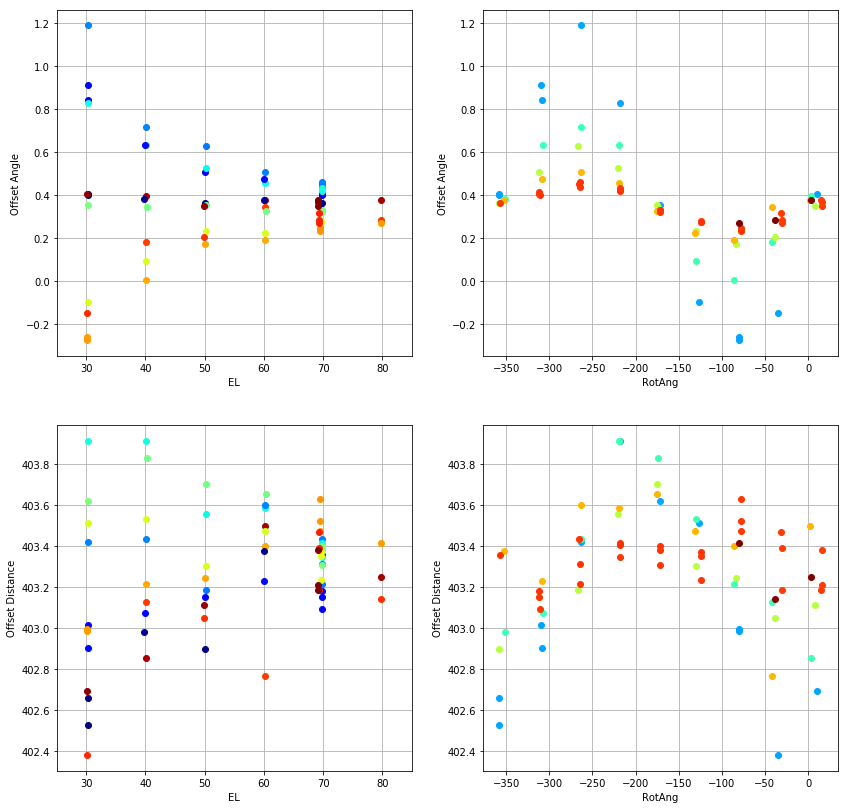

In [121]:
plt.figure(figsize=(14,14))

plt.subplot(2,2,1)
# plt.plot(t['EL'], t['OffsetAngle'], 'ko')
for entry in t:
    plt.plot(entry['EL'], entry['OffsetAngle'], 'ko', color=cm.jet( (entry['RotAng']-mnra)/(mxra-mnra) ))
plt.xlabel('EL')
plt.ylabel('Offset Angle')
plt.xlim(25,85)
plt.grid()

plt.subplot(2,2,2)
# plt.plot(t['RotAng'], t['OffsetAngle'], 'ko')
for entry in t:
    plt.plot(entry['RotAng'], entry['OffsetAngle'], 'ko', color=cm.jet( (entry['EL']-10)/70 ))
plt.xlabel('RotAng')
plt.ylabel('Offset Angle')
#plt.xlim(0,360)
plt.grid()

plt.subplot(2,2,3)
# plt.plot(t['EL'], t['OffsetDistance'], 'ko')
for entry in t:
    plt.plot(entry['EL'], entry['OffsetDistance'], 'ko', color=cm.jet( (entry['RotAng']-mnra)/(mxra-mnra) ))
plt.xlabel('EL')
plt.ylabel('Offset Distance')
plt.xlim(25,85)
plt.grid()

plt.subplot(2,2,4)
# plt.plot(t['RotAng'], t['OffsetDistance'], 'ko')
for entry in t:
    plt.plot(entry['RotAng'], entry['OffsetDistance'], 'ko', color=cm.jet( (entry['EL']-10)/70 ))
plt.xlabel('RotAng')
plt.ylabel('Offset Distance')
#plt.xlim(0,360)
plt.grid()

plt.show()

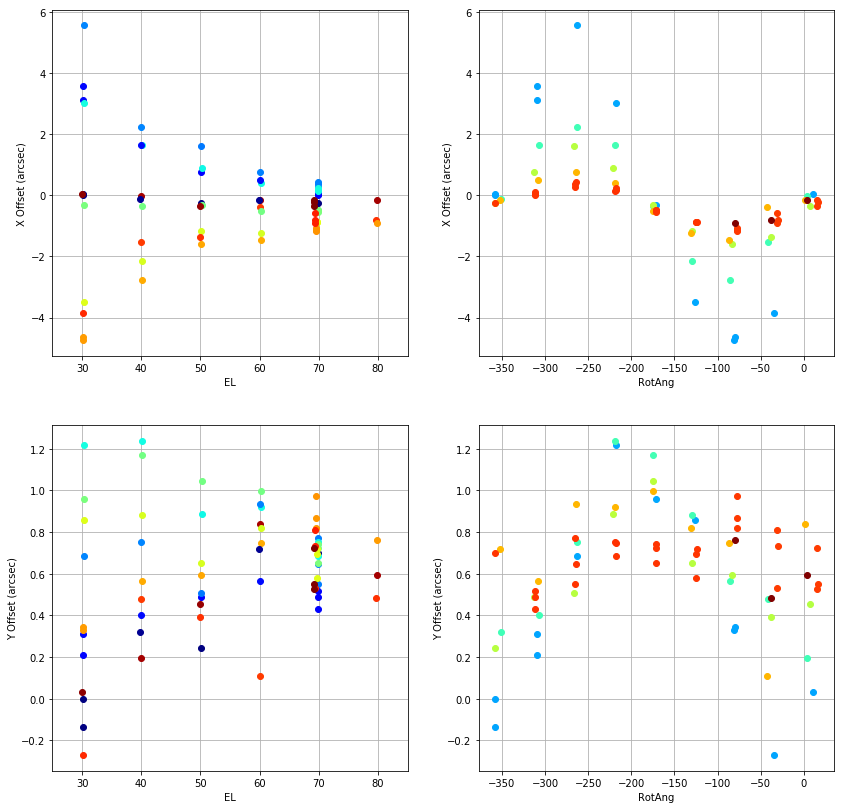

In [122]:
plt.figure(figsize=(14,14))

plt.subplot(2,2,1)
for i,entry in enumerate(t):
    plt.plot(entry['EL'], entry['Xoffset'], 'ko', color=cm.jet( (entry['RotAng']-mnra)/(mxra-mnra) ))
plt.xlabel('EL')
plt.ylabel('X Offset (arcsec)')
plt.xlim(25,85)
plt.grid()

plt.subplot(2,2,2)
for i,entry in enumerate(t):
    plt.plot(entry['RotAng'], entry['Xoffset'], 'ko', color=cm.jet( (entry['EL']-10)/70 ))
plt.xlabel('RotAng')
plt.ylabel('X Offset (arcsec)')
#plt.xlim(0,360)
plt.grid()

plt.subplot(2,2,3)
for i,entry in enumerate(t):
    plt.plot(entry['EL'], entry['Yoffset'], 'ko', color=cm.jet( (entry['RotAng']-mnra)/(mxra-mnra) ))
plt.xlabel('EL')
plt.ylabel('Y Offset (arcsec)')
plt.xlim(25,85)
plt.grid()

plt.subplot(2,2,4)
for i,entry in enumerate(t):
    plt.plot(entry['RotAng'], entry['Yoffset'], 'ko', color=cm.jet( (entry['EL']-10)/70 ))
plt.xlabel('RotAng')
plt.ylabel('Y Offset (arcsec)')
#plt.xlim(0,360)
plt.grid()

plt.show()

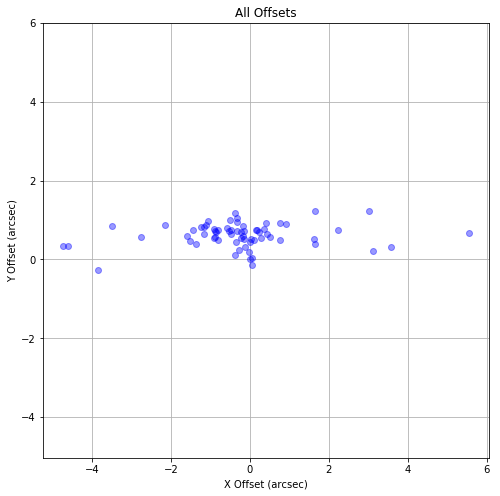

In [123]:
plt.figure(figsize=(8,8))
plt.title('All Offsets')
plt.plot(t['Xoffset'], t['Yoffset'], 'bo', alpha=0.4)
plt.xlabel('X Offset (arcsec)')
plt.ylabel('Y Offset (arcsec)')
plt.gca().axis('equal')
plt.grid()
plt.show()

In [119]:
t[60:65]

Filename,EL,PA,RotAng,GuiderCoord,ImageCoord,OffsetDistance,OffsetAngle,Xoffset,Yoffset
str17,float64,float64,float64,str24,str24,float64,float64,float64,float64
m190515_0069.fits,69.29444241,135.220112,-30.35792145,19:05:40.38 +39:52:34.82,19:05:15.82 +39:57:22.71,403.3903496721957,0.28343289320787335,-0.8020518163874948,0.735128179580613
m190515_0070.fits,69.20004175,180.2198695,15.51227584,19:05:40.38 +39:52:34.82,19:05:40.74 +39:59:17.98,403.1860629796675,0.3757965365407472,-0.15311724496196133,0.5271049006441331
m190515_0071.fits,69.18219617,180.21998923,15.73332992,19:05:40.38 +39:52:34.82,19:05:40.73 +39:59:18.18,403.3820844641689,0.34908473480714974,-0.33988812067899454,0.7243117895206979
m190515_0072.fits,69.16454589,180.21985924,15.94315448,19:05:40.38 +39:52:34.82,19:05:40.74 +39:59:18.01,403.20972776896514,0.3659701667322679,-0.22211206157299968,0.5512168047018235
m190515_0075.fits,79.77591587,180.21977701,3.32732502,19:29:38.67 +29:52:28.33,19:29:38.99 +29:59:11.56,403.2509868585834,0.37414222810159004,-0.16433428810756645,0.5921035803471
